### Univariate Statistics:
+ consider each feature individually
+ discard feature in case it is predictive in combination with another feature
+ don't require building a model --> fast to compute


**For regression**: f_regression, mutual_info_regression.

**For classification**: chi2, f_classif, mutual_info_classif

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cancer = load_breast_cancer()

# Deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
print('Noise features shape: {}'.format(noise.shape))
print('Original features shape: {}\n'.format(cancer.data.shape))
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target,
                                                    random_state=42, test_size=0.5)

# Select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
print('With noise X_train shape: {}'.format(X_train.shape))
print('Selected X_train shape: {}\n'.format(X_train_selected.shape))
print(select.get_params())

Noise features shape: (569, 50)
Original features shape: (569, 30)

With noise X_train shape: (284, 80)
Selected X_train shape: (284, 40)

{'percentile': 50, 'score_func': <function f_classif at 0x7f81334f1d90>}


[ True  True  True  True  True  True  True  True  True  True  True False
  True  True False  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False False False False False False  True False False False  True
 False False False False False False  True False False False  True False
 False False  True False False False  True  True  True False False False
  True  True False False False False  True  True]


Text(0.5, 0, 'Index')

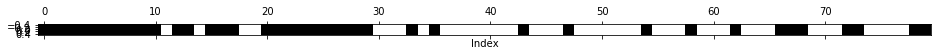

In [3]:
# Find out selected features
mask = select.get_support()
print(mask)
# Black - true, white - false
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Index')

# Not perfect recovery of original features

In [4]:
X_test_selected = select.transform(X_test)
lr = LogisticRegression(solver='lbfgs', max_iter=100000)
lr.fit(X_train, y_train)
print('Score with noise features: {:.3f}'.format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print('Score with selected 40 feat.: {:.3f}'.format(lr.score(X_test_selected, y_test)))
# Score improved

Score with noise features: 0.961
Score with selected 40 feat.: 0.965


### Model-Based Feature Selection

Intuition: keep the most important features found by supervised models.
1. Tree-based -->  feature_importances_
2. Linear models --> coef_

In [5]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [6]:
# Select all features that have importances greater than threshold
# RF model to compute feature importances
# Median threshold - select half of features

select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                         threshold='median')

select.fit(X_train, y_train) # train
X_train_sel = select.transform(X_train) # select
print('Before selection: {}'.format(X_train.shape))
print('After selection: {}\n'.format(X_train_sel.shape))
print(select.get_params())

Before selection: (284, 80)
After selection: (284, 40)

{'estimator__bootstrap': True, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10

Text(0.5, 0, 'Index')

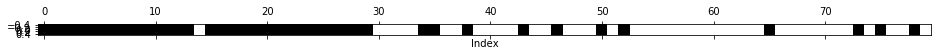

In [7]:
# Find out selected features

mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Index')

# More original features selected!

In [8]:
# Check performance

X_test_sel = select.transform(X_test) # select
print('Score before selection: {:.3f}'.format(LogisticRegression(solver='liblinear',
                                                                max_iter=100000).fit(X_train,
                                                                                     y_train).score(X_test,
                                                                                                    y_test)))
print('Score after selection: {:.3f}'.format(LogisticRegression(solver='liblinear',
                                                                max_iter=100000).fit(X_train_sel,
                                                                                     y_train).score(X_test_sel,
                                                                                                    y_test)))
# Accuracy improved

Score before selection: 0.940
Score after selection: 0.958


In [9]:
for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    lr = LogisticRegression(solver=solver, max_iter=100000)
    lr.fit(X_train, y_train)
    print('Solver {}, accuracy before selection {:.3f}'.format(solver, lr.score(X_test, y_test)))
    lr.fit(X_train_sel, y_train)
    print('Solver {}, accuracy after selection {:.3f}\n'.format(solver, lr.score(X_test_sel, y_test)))

Solver newton-cg, accuracy before selection 0.961
Solver newton-cg, accuracy after selection 0.951

Solver lbfgs, accuracy before selection 0.961
Solver lbfgs, accuracy after selection 0.951

Solver liblinear, accuracy before selection 0.940
Solver liblinear, accuracy after selection 0.958

Solver sag, accuracy before selection 0.944
Solver sag, accuracy after selection 0.944

Solver saga, accuracy before selection 0.944
Solver saga, accuracy after selection 0.944



### Iterative Feature Selection

1. Start with no features and add features one by one until stopping criterion is reached.
2. Start with all features and remove features one by one until some stopping criterion is reached.

In [10]:
from sklearn.feature_selection import RFE, RFECV

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

Text(0.5, 0, 'Index')

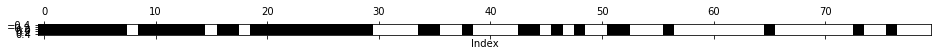

In [11]:
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40, verbose=8)

select.fit(X_train, y_train)

mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Index')

In [12]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)
score = LogisticRegression(solver='lbfgs', max_iter=100000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print('Test score: {:.3f}'.format(score))

Test score: 0.958
